In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import pyodbc
import json
import datetime
from sqlalchemy.engine import URL
from sqlalchemy import create_engine


import matplotlib
import seaborn as sns
from IPython.display import display

#### Defining Default Values

In [2]:
# Set up the default parameters for database connection
server = 'finance-data.database.windows.net'
database = 'DATA'
username = 'johnhuang2499'
password = '' # NOT GIVEN ON GITHUB   
driver= '{ODBC Driver 17 for SQL Server}'

# Set up the default parameters for model testing
initial_capital = 100000
transaction_amount = 500

#### Defining Useful Classes

In [3]:
# Set up a JSON parser class
class JsonParser:
  key_info = {}
  decision = pd.DataFrame()

  # Constructor
  def __init__(self, file_name, info_params):
    # Load the parameters and file
    self.info_params = info_params
    with open(file_name, 'r') as f:
      self.load = json.load(f)

    # Parse the file to get the needed info
    self.parse()

  # For parsing the JSON file
  def parse(self):
    # Load the key info
    info = self.load['info']
    for par in self.info_params:
      self.key_info[par] = info[par]

    # Load the decision and enriched the decision dataFrame
    self.decision = pd.DataFrame(self.load['decision'])
    self.decision['Date'] = pd.to_datetime(self.decision['Date'])
    self.decision.set_index('Date', inplace=True)
    self.decision = self.decision.add_suffix('_Action')
    self.decision = self.decision.reindex(pd.date_range(self.key_info['start_date'], self.key_info['end_date']), fill_value=0)
    self.decision.index.name = 'Date'

In [4]:
# Set up definition for a model
class Model:
  port = pd.DataFrame()
  model_eval = pd.DataFrame()

  # Constructor
  def __init__(self, tickers, start_date, end_date, decision, init_weight, init_invested, init_cash):
    self.tickers = tickers
    self.start_date = start_date
    self.end_date = end_date
    self.decision = decision
    self.init_weight = init_weight
    self.init_invested = init_invested
    self.init_cash = init_cash

  # Construct the portfolio
  # Taking in a dataframe of the returns of tickers
  def constructPort(self, returns):
    # Initialize the portfolio with the returns of the stocks and the decisions
    port = returns[self.tickers].merge(self.decision, how='left', on='Date')

    # Initialize the Cash Change and Positions column
    port['Cash_Change'] = 0
    port['Position'] = 0

    # Find the portfolio value
    for ticker in self.tickers:
      # Calculate the initial amount of shares
      port[ticker + '_Shares'] = self.init_invested * self.init_weight[ticker] / port[ticker][0]

      # Calculate the entry/exit shares at the end of the day based on the algo decision
      port[ticker + '_Change'] = port[ticker + '_Action'] / port[ticker]

      # Calculate the total amount of shares at the start of each day
      port[ticker + '_Shares'] += port[ticker + '_Change'].shift(1).cumsum()

      # Add the positional value for each stock
      port['Position'] += port[ticker] * port[ticker + '_Shares']

      # Find the cash change and total cash in the portfolio
      port['Cash_Change'] -= port[ticker + '_Action']
    
    # Calculate the total cash and total value
    port['Cash'] = port['Cash_Change'].cumsum() + self.init_cash
    port['Portfolio_Total'] = port['Position'] + port['Cash']

    # Calculate the daily return and culmulative return 
    port['Daily_Return'] = port['Portfolio_Total'].pct_change()
    port['Cumulative_Return'] = (1 + port['Daily_Return']).cumprod() - 1

    # Assign to built portfolio to self
    self.port = port
  
  # Get important statistical data
  def performModelEval(self):
    # Prepare dataframe for metrics
    metrics = [
      'Return',
      'Annual_Return',
      'Annual_Volatility',
      'Sharpe_Ratio'
    ]
    annual_trading_days = 252

    # Initialize the DataFrame with index set to evaluation metrics and column as 'Backtest'
    portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=['Values'])
    portfolio_evaluation_df.index.name = 'Metrics'
    # Calculate cumulative returns:
    portfolio_evaluation_df.loc['Return'] = self.port['Cumulative_Return'][-1]
    # Calculate annualized returns:
    portfolio_evaluation_df.loc['Annual_Return'] = (self.port['Daily_Return'].mean() * annual_trading_days)
    # Calculate annual volatility:
    portfolio_evaluation_df.loc['Annual_Volatility'] = (self.port['Daily_Return'].std() * np.sqrt(annual_trading_days))
    # Calculate Sharpe Ratio:
    portfolio_evaluation_df.loc['Sharpe_Ratio'] = portfolio_evaluation_df.loc['Annual_Return'] / portfolio_evaluation_df.loc['Annual_Volatility']

    self.model_eval = portfolio_evaluation_df

  # Get important return data
  def getReturnData(self):
    return self.port[['Daily_Return', 'Cumulative_Return']].dropna()
  
  # Get the model evaluation data
  def getModelEval(self):
    self.performModelEval()
    return self.model_eval


#### Data ETL

In [5]:
# Parse the JSON file 
parsed_data = JsonParser('fama_french.json', ['tickers', 'start_date', 'end_date', 'init_weight', 'init_capital_invested'])

# Further enrich the data with default information
tickers = parsed_data.key_info['tickers']
start_date = parsed_data.key_info['start_date']
end_date = parsed_data.key_info['end_date']
init_weight = parsed_data.key_info['init_weight']
init_invested = parsed_data.key_info['init_capital_invested'] * initial_capital
init_cash = initial_capital - init_invested
decision = parsed_data.decision * transaction_amount

# Display
start_date, end_date, init_weight, init_invested, init_cash

('2023-03-01',
 '2023-05-02',
 {'AAPL': 0.2049078933530066,
  'MSFT': 0.4512569267665079,
  'TSLA': 0.2657803733506336,
  'META': 0.012609613390299607,
  'AMZN': 0.06544519313955227},
 80000.0,
 20000.0)

#### Connection to the Database and Retrieve Finance Data

In [6]:
# Create a connection to the database
connection_string = 'DRIVER='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
engine = create_engine(connection_url)

In [7]:
# Load the necessary data
with engine.begin() as conn:
  for ticker in tickers:
    # Find the date range of the data to load that is not already in the database
    date_gap_query = f'select * from dbo.fn_get_adj_close_date_gaps(\'{ticker}\',\'{start_date}\', \'{end_date}\')'
    data_to_load = pd.read_sql(date_gap_query, conn)
    
    # Skip loading data if it is empty
    if data_to_load.empty:
      print('Data already exists for ' + ticker)
      continue
    
    # Get the data needed from yfinance api
    for index, row in data_to_load.iterrows():
      target_start = row['start_date']
      target_end = row['end_date']
      ticker_data = yf.download(ticker, target_start, target_end, interval='1d')[['Adj Close']]

      # Insert the data into the data table
      insert_data_query = 'insert into dbo.adj_close (ticker, date, value) values '
      for t_index, t_row in ticker_data.iterrows():
        date = datetime.datetime.strftime(t_index, '%Y-%m-%d')
        close = t_row['Adj Close']
        insert_data_query += f'(\'{ticker}\', \'{date}\', \'{close}\'),'
      
      insert_data_query = insert_data_query[:-1]
      conn.execute(insert_data_query)

      # Insert the updated range to the xref table
      insert_xref_query = 'insert into dbo.adj_close_xref (ticker, start_date, end_date) values '
      insert_xref_query +=  f'(\'{ticker}\', \'{start_date}\', \'{end_date}\')'
      conn.execute(insert_xref_query)

      print('Data loaded for ' + ticker)


Data already exists for AAPL
Data already exists for MSFT
Data already exists for TSLA
Data already exists for META
Data already exists for AMZN


In [8]:
# Get all the returns data
returns = pd.DataFrame(pd.date_range(start_date, end_date), columns=['Date'])
returns.set_index('Date', inplace=True)

# Retrieve the stock data needed for the date range
with engine.begin() as conn:
  for ticker in tickers:
    retrival_query = f'''
      select [date], [value] from dbo.adj_close 
        where [ticker] = \'{ticker}\' and \'{start_date}\' <= [date] and [date] <= \'{end_date}\' order by [date]
      '''

    price_data = pd.read_sql(retrival_query, conn)
    price_data.rename(columns = {'date' : 'Date', 'value' : ticker}, inplace=True)
    price_data.set_index('Date', inplace=True)
    price_data.index = pd.to_datetime(price_data.index)

    returns = returns.merge(price_data, on='Date')

display(returns.tail())    

,AAPL,MSFT,TSLA,META,AMZN
Date,,,,,
2023-04-25,163.770004,275.420013,160.669998,207.550003,102.570000
2023-04-26,163.759995,295.369995,153.750000,209.399994,104.980003
2023-04-27,168.410004,304.829987,160.190002,238.559998,109.820000
2023-04-28,169.679993,307.260010,164.309998,240.320007,105.449997
2023-05-01,169.589996,305.559998,161.830002,243.179993,102.050003


#### Model Construction

In [9]:
# Construct the model given by the decision
test_model = Model(tickers, start_date, end_date, decision, init_weight, init_invested, init_cash)
test_model.constructPort(returns)

#### Analysis

In [10]:
# Construct an underlying model for comparison
# with equal weights and no transactions and all invested initially
no_decision = decision * 0
equal_weight = dict([(name, (1.0 / len(tickers))) for name in tickers])
bench_model = Model(tickers, start_date, end_date, no_decision, equal_weight, init_invested + init_cash, 0)
bench_model.constructPort(returns)

# Construct a model for each individual ticker
ticker_models = {}

for ticker in tickers:
  custom_weight = dict([(name, 0) for name in tickers])
  custom_weight[ticker] = 1.0
  single_model = Model([ticker], start_date, end_date, no_decision, custom_weight, init_invested + init_cash, 0)
  single_model.constructPort(returns)
  ticker_models[ticker] = single_model

In [11]:
# Store as CSV for some 
try:
  test_model.getReturnData().to_csv('_Test_Model.csv')
  bench_model.getReturnData().to_csv('_Bench_Model.csv')
except PermissionError:
  print ('Permission Error')

In [12]:
# compare_eval the evaluation of different models
compare_eval = test_model.getModelEval().rename(columns={'Values' : 'Test'})
compare_eval = compare_eval.merge(bench_model.getModelEval().rename(columns={'Values' : 'Bench'}), on='Metrics')

# Add each individual ticker models
for name, model in ticker_models.items():
  compare_eval = compare_eval.merge(model.getModelEval().rename(columns={'Values' : name}), on='Metrics')

display(compare_eval)

,Test,Bench,AAPL,MSFT,TSLA,META,AMZN
Metrics,,,,,,,
Return,0.06917,0.149699,0.162292,0.216837,-0.152279,0.393342,0.107674
Annual_Return,0.432132,0.90026,0.946963,1.252616,-0.876072,2.150905,0.688519
Annual_Volatility,0.206478,0.293416,0.207792,0.30122,0.528796,0.473068,0.349197
Sharpe_Ratio,2.092876,3.068204,4.557263,4.158476,-1.656729,4.546715,1.971717


In [13]:
# compare the return of different models
compare_ret = test_model.getReturnData()[['Cumulative_Return']].rename(columns={'Cumulative_Return':'Test'})
compare_ret = compare_ret.merge(bench_model.getReturnData()[['Cumulative_Return']].rename(columns={'Cumulative_Return':'Bench'}), on='Date')

# Add each individual ticker models
for name, model in ticker_models.items():
  compare_ret = compare_ret.merge(model.getReturnData()[['Cumulative_Return']].rename(columns={'Cumulative_Return':name}), on='Date')

display(compare_ret)

,Test,Bench,AAPL,MSFT,TSLA,META,AMZN
Date,,,,,,,
2023-03-03,0.021425,0.035817,0.035090,0.016646,0.036092,0.061422,0.030066
2023-03-06,0.022055,0.034120,0.054280,0.022938,0.015244,0.059417,0.017584
2023-03-07,0.008959,0.021871,0.038997,0.012106,-0.016710,0.057182,0.015413
2023-03-08,0.003771,0.018938,0.047701,0.010314,-0.046621,0.059818,0.019429
2023-03-09,-0.006877,-0.001803,0.032075,0.004819,-0.094185,0.041024,0.001303
2023-03-10,-0.004872,-0.013073,0.017751,-0.010035,-0.091461,0.028534,-0.015196
2023-03-13,0.002016,0.000362,0.031252,0.011190,-0.086014,0.036498,0.003256
2023-03-14,0.029842,0.038184,0.045782,0.038549,-0.040021,0.111671,0.029849
2023-03-15,0.033746,0.046956,0.048523,0.057067,-0.054741,0.133043,0.044177


<Axes: xlabel='Date'>

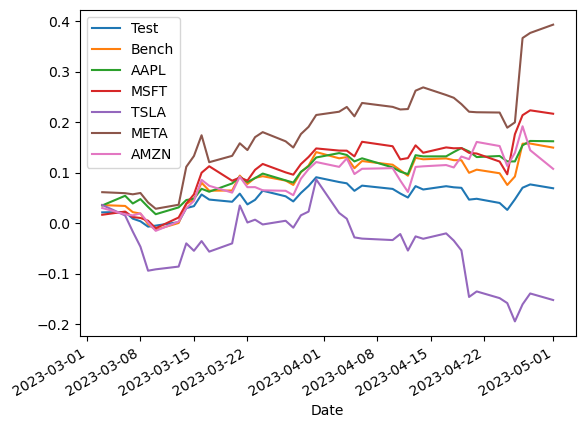

In [14]:
# plot the returns
compare_ret.plot()